**Reinforcement Learning for Stock Price Prediction**


**A Q-learning Agent for Automated Trading in Equity Stock Markets**


**IMPLEMENTATION OF METHOD 1 : CLUSTER TO REPRESENT A STATE**

Installing few necessary python libraries for our model

In [ ]:
!pip install ta

  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=45d8d42af5aa7eb176f19f9491c730fd700108e995a1a1ae0ea4c27a3f5e6c32
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta


In [ ]:
!pip install nsepy

  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36085 sha256=d4c2d102cf59cefb42fafb279393a4cc823b86a2ba56a1752c37df0329c106cc
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy


In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import nsepy
import ta
from pandas_datareader import data
from sklearn.cluster import KMeans
%matplotlib inline

In [ ]:
#mounting gdrive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting the data excel sheet present in google drive

In [ ]:
data_dji=pd.read_csv('/content/drive/MyDrive/RL project/DJI.csv')

In [ ]:
data_dji.head()   #first five elements of DJIA data set

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-10-19,10142.980469,10014.610352,10014.610352,10142.980469,343710000,10142.980469
1,2000-10-20,10229.549805,10067.509766,10141.129883,10226.589844,319750000,10226.589844
2,2000-10-23,10361.250000,10216.230469,10230.290039,10271.719727,339180000,10271.719727
3,2000-10-24,10439.309570,10273.570312,10273.570312,10393.070312,274990000,10393.070312
4,2000-10-25,10461.969727,10306.589844,10395.660156,10326.480469,312490000,10326.480469


In [ ]:
data_dji.tail()  #last five elements of DJIA data set

,Date,High,Low,Open,Close,Volume,Adj Close
4572,2018-12-24,22339.869141,21792.199219,22317.279297,21792.199219,308420000,21792.199219
4573,2018-12-26,22878.919922,21712.529297,21857.730469,22878.449219,433080000,22878.449219
4574,2018-12-27,23138.890625,22267.419922,22629.060547,23138.820312,407940000,23138.820312
4575,2018-12-28,23381.880859,22981.330078,23213.609375,23062.400391,336510000,23062.400391
4576,2018-12-31,23333.179688,23118.300781,23153.939453,23327.460938,288830000,23327.460938


In [ ]:
data_dji.info()  #general information about the data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4577 entries, 0 to 4576
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4577 non-null   object 
 1   High       4577 non-null   float64
 2   Low        4577 non-null   float64
 3   Open       4577 non-null   float64
 4   Close      4577 non-null   float64
 5   Volume     4577 non-null   int64  
 6   Adj Close  4577 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 250.4+ KB


In [ ]:
def data_preprocessing():
    data_djia=pd.read_csv('/content/drive/MyDrive/RL project/DJI.csv')  #reading djia file

    data_djia['Date']= pd.to_datetime(data_djia["Date"])   #making datetime data type for calculations
    data_djia['weekday'] = data_djia['Date'].dt.dayofweek     #for number representing day of week

    data_djia['rsi']=ta.momentum.RSIIndicator(data_djia["Close"], window=14).rsi()   #used to indicate how hot a stock is
    data_djia['r']=ta.momentum.WilliamsRIndicator(data_djia["High"], data_djia["Low"], data_djia["Close"], lbp=14).williams_r()   #calcuting williams%r
    data_djia['cci']=ta.trend.CCIIndicator(data_djia["High"], data_djia["Low"], data_djia["Close"], window=20, constant=0.015).cci()  #calculating CCI

    data_djia['O']=((data_djia['Open']-data_djia['Close'].shift(1))/data_djia['Close'].shift(1))*100   #Percentage relationship between open and close for two consecutive days
    data_djia['H']=(data_djia['High']-data_djia['Open'])/data_djia['Open']*100  #Percentage increase from open price
    data_djia['L']=(data_djia['Low']-data_djia['Open'])/data_djia['Open']*100   #Percentage decrease from open price
    data_djia['C']=(data_djia['Close']-data_djia['Open'])/data_djia['Open']*100  #percentage increase or decrease of close price from open price 
    data_djia['V']=((data_djia['Volume']-data_djia['Volume'].shift(1))/data_djia['Volume'].shift(1))*100   #Percentage change in volume for two consecutive days

    data_djia = data_djia.dropna(axis = 0, how ='any')  #removing all unecessary rows which contains NaN values
    data_djia = data_djia.reset_index()   #To reset the index of the dataframe due to removing NaN containing rows

    arr_max=np.where(data_djia[['O','H','L','C','V','weekday']].values >= np.finfo(np.float64).max)   #checking if any value is greater than max float value.
    arr_final_max=arr_max[0]  #contains list of all indices whose value is greater than max float value to remove them
    data_djia = data_djia.reset_index()  #resets indices after removing values

    data_djia['cash']=0   #inializing cash column for amount of cash after each episode
    data_djia['action']=""   #creating action column for open short, close short, open long, close long
    data_djia['action1']=""  #creating action1 column for long and short

    return data_djia  #returning the dataframe created

In [ ]:
data_djia=data_preprocessing()  #Calling the preprocessing data function once to see how the data looks like after pre processing
data_djia

,level_0,index,Date,High,Low,Open,Close,Volume,Adj Close,weekday,rsi,r,cci,O,H,L,C,V,cash,action,action1
0,0,19,2000-11-15,10799.370117,10635.940430,10681.209961,10707.599609,189850000,10707.599609,2,56.779071,-46.940841,23.124147,0.001408,1.106243,-0.423824,0.247066,-16.395103,0,,
1,1,20,2000-11-16,10757.660156,10639.349609,10705.330078,10656.030273,175280000,10656.030273,3,53.967809,-55.039553,7.545399,-0.021196,0.488823,-0.616333,-0.460516,-7.674480,0,,
2,2,21,2000-11-17,10762.589844,10565.790039,10657.129883,10629.870117,221680000,10629.870117,4,52.546494,-59.147877,-11.926131,0.010319,0.989572,-0.857077,-0.255789,26.471931,0,,
3,3,22,2000-11-20,10624.280273,10449.280273,10624.179688,10462.650391,203170000,10462.650391,0,44.482086,-85.408915,-73.126317,-0.053532,0.000947,-1.646239,-1.520393,-8.349874,0,,
4,4,23,2000-11-21,10569.009766,10415.250000,10465.570312,10494.500000,191420000,10494.500000,1,46.176433,-80.407090,-86.390488,0.027908,0.988379,-0.480818,0.276427,-5.783334,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,4553,4572,2018-12-24,22339.869141,21792.199219,22317.279297,21792.199219,308420000,21792.199219,0,21.016548,-100.000000,-207.592307,-0.570674,0.101221,-2.352796,-2.352796,-65.750519,0,,
4554,4554,4573,2018-12-26,22878.919922,21712.529297,21857.730469,22878.449219,433080000,22878.449219,2,37.449406,-65.536832,-135.495822,0.300710,4.671983,-0.664301,4.669830,40.418909,0,,
4555,4555,4574,2018-12-27,23138.890625,22267.419922,22629.060547,23138.820312,407940000,23138.820312,3,40.637540,-57.840581,-93.308686,-1.090059,2.252988,-1.598125,2.252678,-5.804932,0,,
4556,4556,4575,2018-12-28,23381.880859,22981.330078,23213.609375,23062.400391,336510000,23062.400391,4,39.993237,-56.676021,-63.855474,0.323219,0.724883,-1.000617,-0.651381,-17.509928,0,,


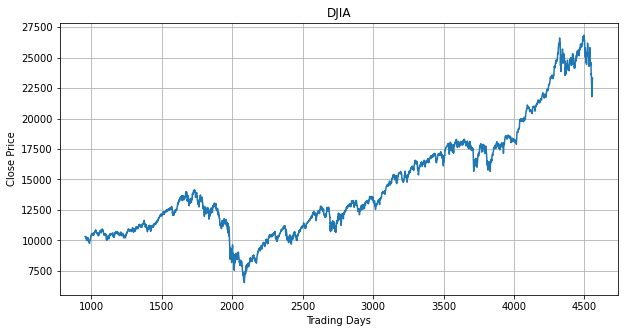

In [ ]:
fig = plt.figure()  #to plot figure
axis=data_djia.loc[956:,'Close'].plot(grid="True",figsize=(10,5), title='DJIA')   #plot from 956th row of Close with trading days Level_0
axis.set_xlabel("Trading Days")  #setting name for x axis
axis.set_ylabel("Close Price")   #setting name for y axis
plt.show()  #to display figure

In [ ]:
class Training_Agent:

    def __init__(self):   #initialising the hyperparameters such as gamma, epsilon , Q table and learning rate(alpha)
        self.gamma = 0.618
        self.epsilon_decay_value = 0.995
        self.epsilon_min_value = 0.01
        self.Q = np.matrix(np.zeros([3,3]))  #3x3 matrix - 3 rows for 3 clusters and 3 columns for 0,1,2 actions
        self.learning_rate= 0.05
        self.epsilon = 1.0
        
    
    def obtainAction(self,state):   #to pick an action
        action_array=[1,0,2]    #0 means to be in the same state(hold), 1 means if we have short then remove, if long continue(sell), 2 is inverse of 1(buy)
        if np.random.rand() <= self.epsilon:   #choosing a random action from a
            return random.choice(action_array)   #returning the random choice chosen
        return np.argmax(self.Q[state,])   #if the random value is more than epsilon, return max of value in Q table
    
    def updateQtable(self,present_state,present_action,reward_obt,next_state,next_action): # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            self.Q[present_state,present_action]= self.Q[present_state,present_action] + self.learning_rate * (reward_obt + self.gamma * np.max(self.Q[next_state, :]) 
                                - self.Q[present_state,present_action])

In [ ]:
def obtainState(kmeans,i):  
        col=data_djia[['O','H','L','C','V','weekday']].iloc[i-1].values   #taking values of that particular day
        col=col.reshape(1,6)   #reshaphing into desired format
        pred_val=kmeans.predict(col)    #using kmeans model to predict the action to perform
        return(pred_val[0])      

In [ ]:
maxprofit=-100000
overall_profit=0
random.seed(101)
episodes=200  #no.of episodes
agent=Training_Agent()   #calling the agent
m1=0 
m2=0

for e in range(1,episodes+1):   #running loop for episode number of times
    data_djia=data_preprocessing()   #obtaining the data frame after performing calculations
    kmeans = KMeans(n_clusters=3, random_state=101).fit(data_djia[['O','H','L','C','V','weekday']].values)  #implements Kmeans clustering with 3 clusters.
    data_length_start=1
    data_length_end=1304    #taking first 1304 table entries of data frame for training
    state = obtainState(kmeans,data_length_start)   #to get the present state.
    action = agent.obtainAction(state)   #to get the random action from 0,1,2
    last_action=None  #last action is none as we just started the episode
    last_price=0   #last price is 0 as we just started episode
    last_quantity=0   #last quantity is 0 as we just started episode
    capital_amount=data_djia.loc[data_length_start,'Open']*100    #capital is the initial money we have and it has been set to open of first day
    margin=data_djia.loc[data_length_start,'Open']*100     #margin is set to open of first day
    broker_rate=0.0010   #the rate we should pay to the broker
    total_profit=0      #initial profit is zero
    print("Episode {}/{}".format(e,episodes))   #printing the episode number we are at currently
    count_pos=0  #Number of position changes

    for i in range(data_length_start,data_length_end):  #variable t in train data.     
        reward=0   #setting reward to zero each time
        if last_action=='sold':  #if previous action was sell, we update profit and brokerage for previous day
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate 
            currprofit=(last_price-data_djia.loc[i,'Open'])*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100
            
            if totprofit1<-10:   #if profit is below 10%, we will stop short as we incurred a huge loss. Hence close short
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin     
                last_action=None
                data_djia.loc[i,'action']="close short"
                data_djia.loc[i,'action1']="long"
                reward= max((np.log(last_price)-np.log(data_djia.loc[i,'Open'])),0)

        elif last_action=='bought':   #if last action is bought, then again we update variables for previous day
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(data_djia.loc[i,'Open']-last_price)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1<-10:   #if profit upon buying is less than 10% then we close long
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin        
                last_action=None
                data_djia.loc[i,'action']="close long"
                data_djia.loc[i,'action1']="short"
                reward= max((np.log(data_djia.loc[i,'Open'])-np.log(last_price)),0)               
                          
            
        if action == 1  and last_action==None :  #if no previous action then we should open long for action = 1
            data_djia.loc[i,'cash']=margin            
            last_quantity=margin//data_djia.loc[i,'Open']
            margin=margin%data_djia.loc[i,'Open']
            last_action='bought'   #Since we bought now as we opened long, last action is bought
            last_price=data_djia.loc[i,'Open']  #last price becomes open price currently
            data_djia.loc[i,'action']="open long"
            data_djia.loc[i,'action1']="long"
            count_pos+=1

        elif action == 1  and last_action=='sold':  #If action is 1 and sold was happening before, then we close short
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(last_price-data_djia.loc[i,'Open']-totbrokerage)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1>10 or totprofit1<-5:   #close short if this does not happen
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin      
                data_djia.loc[i,'action']="close short"
                data_djia.loc[i,'action1']="long"
                last_action=None
                reward= max((np.log(last_price)-np.log(data_djia.loc[i,'Open']+totbrokerage)),0)

            else:
                prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity  #Calculating total profit  #tp
                original=margin+(last_quantity*last_price)
                data_djia.loc[i,'cash']=original+prof_tot  
                
        elif action == 1  and last_action=='bought':  #If action is 1 and we bought (long), then we continue or hold long position
            data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close'])

        elif action == 2  and last_action==None and margin>data_djia.loc[i,'Open']:    #If action is 2 and we did nothing then we start short( open short ). But if our margin is less than open, then we dont
            data_djia.loc[i,'cash']=margin        
            last_quantity=margin//data_djia.loc[i,'Open']
            margin=margin%data_djia.loc[i,'Open']
            last_price=data_djia.loc[i,'Open']
            last_action='sold'        
            data_djia.loc[i,'action']="open short"
            data_djia.loc[i,'action1']="short"      
            count_pos+=1

        elif action == 2  and last_action=='sold':    #If action is 2 and last action was sold(short), then we continue in short(hold)
            prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
            original=margin+(last_quantity*last_price)
            data_djia.loc[i,'cash']=original+prof_tot

        elif action == 2 and  last_action=='bought':  #If action is 2 and last action was bought then we close long 
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(data_djia.loc[i,'Open']-last_price-totbrokerage)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1>10 or totprofit1<-5:
              total_profit=total_profit+currprofit 
              margin=margin+(last_quantity*last_price)+currprofit
              data_djia.loc[i,'cash']=margin        
              last_action=None
              data_djia.loc[i,'action']="close long"
              data_djia.loc[i,'action1']="short"
              reward= max((np.log(data_djia.loc[i,'Open'])-np.log(last_price+totbrokerage)),0) 

            else:
              data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close'])

        else:            
            if last_action==None:   #if no last action then we just stay in that current position
                data_djia.loc[i,'cash']=margin 
            elif last_action=='bought':
                data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close']) 
            elif last_action=='sold':
                prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                data_djia.loc[i,'cash']=original+prof_tot
                                       
              
        next_state=obtainState(kmeans,i+1)   #we get the next state every time
        next_action=agent.obtainAction(next_state)   #we get the next action every time
        agent.updateQtable(state,action,reward,next_state,next_action)   #Here we update the Qtable
        state=next_state     
        action=next_action
        
        if i==data_length_end-2:  #We are in the last but one row for that particular episode, we print results of that episode after predicting last row stock
                print("--------------------------------\n")

                if  last_action=='sold':  #we calculate profit and close short
                    totbrokerage=(data_djia.loc[i,'Close']+last_price)*broker_rate
                    currprofit=(last_price-data_djia.loc[i,'Close']-totbrokerage)*last_quantity
                    total_profit=total_profit+currprofit
                    margin=margin+(last_quantity*last_price)+(currprofit) 
                    data_djia.loc[i,'cash']=margin
                    last_action=None
                    data_djia.loc[i,'action']="close short"
                    data_djia.loc[i,'action1']="long"

                elif last_action=='bought':  #we calculate profit and close long
                    totbrokerage=(data_djia.loc[i,'Close']+last_price)*broker_rate
                    currprofit=(data_djia.loc[i,'Close']-last_price-totbrokerage)*last_quantity
                    total_profit=total_profit+currprofit
                    margin=margin+(last_quantity*last_price)+(currprofit) 
                    data_djia.loc[i,'cash']=margin
                    last_action=None
                    data_djia.loc[i,'action']="close long"
                    data_djia.loc[i,'action1']="short"
                print("***********************\n")
                print("Total Profit is ",total_profit)  #printing profit
                maxprofit=max(maxprofit,total_profit)   #printing maxprofit
                overall_profit+=total_profit   #printing overall profit or loss obtained
                print("Initial Capital is ",capital_amount)    
                print("Current Capital is ",margin)
                roi=((margin-capital_amount)/capital_amount)*100  #return of interest
                print("Percentage Return of Interest is ",roi)
                buyandhold=((data_djia.loc[i,'Close']-data_djia.loc[data_length_start,'Close'])/data_djia.loc[data_length_start,'Close'])*100
                print("% Buy and Hold=",buyandhold)  
                print("Total count of changing states is",count_pos)
                print("The Qtable is ",agent.Q)
                print("The final value of Epsilon",agent.epsilon)
                print("--------------------------------")
                       
        if (agent.epsilon > agent.epsilon_min_value) and e>1:   
                       agent.epsilon *= agent.epsilon_decay_value 
                      
    
    m3=roi
    if m3>m2: 
        m1=e
        m2=m3
    #To save model            
    np.save('/content/drive/MyDrive/RL project/train_model1/Qtable/'+ str(e)+str('.npy'), agent.Q)
    np.save('/content/drive/MyDrive/RL project/train_model1/Epsilon/'+ str(e)+str('.npy'), agent.epsilon)
    np.save('/content/drive/MyDrive/RL project/train_model1/Gamma/'+ str(e)+str('.npy'), agent.gamma)
    np.save('/content/drive/MyDrive/RL project/train_model1/Learning_rate/'+ str(e)+str('.npy'), agent.learning_rate)
    data_djia.to_csv('/content/drive/MyDrive/RL project/train_model1/AfterTrain'+str(e)+str('.csv'))
print("e={},roi={} \n".format(m1,m2))
print("Max profit is: {}".format(maxprofit))
print("Overall profit is :{}".format(overall_profit))

Episode 1/200
--------------------------------

***********************
Profit is  186563.44873632808
Initial Capital is  1070533.0078125
Current Capital is  1257096.4565488282
%ROI is  17.427155199777275
% Buy and Hold= 0.5040334867608616
count 21
qtable [[1.76565657e-03 3.03527236e-03 2.82347369e-03]
 [5.94151718e-05 0.00000000e+00 0.00000000e+00]
 [1.43910095e-03 1.44162630e-03 1.57737359e-03]]
epsilon 1.0
--------------------------------
Episode 2/200
--------------------------------

***********************
Profit is  -411279.2126323242
Initial Capital is  1070533.0078125
Current Capital is  659253.7951801757
%ROI is  -38.41817203494938
% Buy and Hold= 0.5040334867608616
count 21
qtable [[0.00095376 0.00098289 0.0009816 ]
 [0.00011187 0.         0.        ]
 [0.00028117 0.0002384  0.00023742]]
epsilon 0.00998645168764533
--------------------------------
Episode 3/200
--------------------------------

***********************
Profit is  -419362.4777802734
Initial Capital is  1070533

In [ ]:
Q=np.load('/content/drive/MyDrive/RL project/train_model1/Qtable/200.npy')
Q

array([[0.00036397, 0.00019787, 0.00087012],
       [0.00108399, 0.        , 0.        ],
       [0.00023949, 0.00027862, 0.00029525]])

TEST

In [ ]:
class Testing_Agent:
    def __init__(self):
        self.gamma = np.load('/content/drive/MyDrive/RL project/train_model1/Gamma/200.npy')
        self.Q = Q
        self.learning_rate=  np.load('/content/drive/MyDrive/RL project/train_model1/Learning_rate/200.npy')
        self.epsilon = np.load('/content/drive/MyDrive/RL project/train_model1/Epsilon/200.npy')
        
    
    def obtainAction(self,state):   #same as above 
        action_arr=[1,0,2]
        if np.random.rand() <= self.epsilon:
            return random.choice(action_arr)
        return np.argmax(self.Q[state,]) 
    
    def updateQtable(self,present_state,present_action,reward,next_state,next_action):  # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            self.Q[present_state,present_action]= self.Q[present_state,present_action] + self.learning_rate * (reward + self.gamma * np.max(self.Q[next_state, :])
                                                                - self.Q[present_state,present_action])

In [ ]:
def predictor(djia,i):  #To predit when to sell or buy or hold
    sbh=[0,0,0]
    #0-hold 1-buy 2-sell
    rsi=djia['rsi'][:i+1]
    if(rsi[i]>=70):
        sbh[0]=2  #better to sell due to being overbought
    elif (rsi[i]<=30):
         sbh[0]=1  #better to buy due to oversold
    else:
         sbh[0]=0  #do nothing
    r=djia['r'][:i+1]
    if(r[i]>=-20):
        sbh[1]=2
    elif (r[i]<=-80):
         sbh[1]=1
    else:
         sbh[1]=0
    cci=djia['cci'][:i+1]
    if(cci[i]<=-100):
        sbh[2]=2
    elif (cci[i]>=100):
         sbh[2]=1
    else:
         sbh[2]=0
    return sbh

In [ ]:
total_profit=0
maxprofit=-1000000
episode_count=1
random.seed(101)
agent=Testing_Agent()
m1=0
m2=0
for e in range(1,episode_count+1):  #running loop for episode number of times
    data_djia=data_preprocessing()  #getting data
    kmeans = KMeans(n_clusters=3, random_state=101).fit(data_djia[['O','H','L','C','V','weekday']].values)  #calling Kmeans clustering
    data_length_start= 1305         
    data_length_end=4557                 
    state = obtainState(kmeans,data_length_start)
    action = agent.obtainAction(state)
    last_action=None  #initially last action is nothing
    last_price=0
    last_quantity=0
    capital=data_djia.loc[data_length_start,'Open']*100
    margin=data_djia.loc[data_length_start,'Open']*100
    broker_rate=0.0010
    total_profit=0    
    print("Episode {}/{}".format(e,episode_count))
    count_pos=0

    for i in range(data_length_start,data_length_end-1):
        z=predictor(data_djia,i)  #in function heading
        z0=z.count(0)  #rsi
        z1=z.count(1)  #williams_r
        z2=z.count(2)  #cci
        y=[z0,z1,z2]
        z3=y.index(max(y)) #maximum of z0,z1,z2 to give the better effect on the stock market based on the previous data. 
        reward=0

        if last_action=='sold':  #If last action was sold 
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(last_price-data_djia.loc[i,'Open'])*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100
            
            if totprofit1<-10:  #If total profit percentage is less than 10, then we close short to prevent further losses
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin      
                last_action=None
                data_djia.loc[i,'action']="close short"
                data_djia.loc[i,'action1']="long"
                reward= max((np.log(last_price)-np.log(data_djia.loc[i,'Open'])),0)

        elif last_action=='bought':  #if last action was bought
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(data_djia.loc[i,'Open']-last_price)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1<-10:   #if total profit percentage is less than 10, then we close long to prevent further losses
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin        
                last_action=None
                data_djia.loc[i,'action']="close long"
                data_djia.loc[i,'action1']="short"
                reward= max((np.log(data_djia.loc[i,'Open'])-np.log(last_price)),0)               
                          
            
        if action == 1 and z3==1 and last_action==None :  #in long
            data_djia.loc[i,'cash']=margin            
            last_quantity=margin//data_djia.loc[i,'Open']
            margin=margin%data_djia.loc[i,'Open']
            last_price=data_djia.loc[i,'Open']
            last_action='bought'
            data_djia.loc[i,'action']="open long"
            data_djia.loc[i,'action1']="long"
            count_pos+=1

        elif action == 1 and z3==1 and last_action=='sold':  #in close short
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(last_price-data_djia.loc[i,'Open']-totbrokerage)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1>4 or totprofit1<-4: #to close short
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin      
                last_action=None
                data_djia.loc[i,'action']="close short"
                data_djia.loc[i,'action1']="long"
                reward= max((np.log(last_price)-np.log(data_djia.loc[i,'Open']+totbrokerage)),0)

            else:
                prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                data_djia.loc[i,'cash']=original+prof_tot   
                
        elif action == 1 and z3==1 and last_action=='bought': #in hold long
            data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close'])

        elif action == 2 and z3==2 and last_action==None and margin>data_djia.loc[i,'Open']:  #in short
            data_djia.loc[i,'cash']=margin        
            last_quantity=margin//data_djia.loc[i,'Open']
            margin=margin%data_djia.loc[i,'Open']
            last_price=data_djia.loc[i,'Open']
            last_action='sold'        #open short
            data_djia.loc[i,'action']="open short"
            data_djia.loc[i,'action1']="short"      
            count_pos+=1

        elif action == 2 and z3==2 and  last_action=='bought':#close long  
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(data_djia.loc[i,'Open']-last_price-totbrokerage)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100
            if totprofit1>4 or totprofit1<-4: #closing long
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin        
                last_action=None
                data_djia.loc[i,'action']="close long"
                data_djia.loc[i,'action1']="short"
                reward= max((np.log(data_djia.loc[i,'Open'])-np.log(last_price+totbrokerage)),0)

            else:
                data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close']) 
                
            
        elif action == 2 and z3==2 and last_action=='sold':   #in hold short
            prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
            original=margin+(last_quantity*last_price)
            data_djia.loc[i,'cash']=original+prof_tot

        else:            
            if last_action==None:
                data_djia.loc[i,'cash']=margin  #in hold 1

            elif last_action=='bought': #in hold 2
                data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close']) 

            elif last_action=='sold': #in hold 3
                prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                data_djia.loc[i,'cash']=original+prof_tot     
                                       
              
        next_state=obtainState(kmeans,i+1)  #getting the next state
        next_action=agent.obtainAction(next_state)  #getting the next action
        agent.updateQtable(state,action,reward,next_state,next_action)  #updating the Qtable
        state=next_state
        action=next_action
        
        if i==data_length_end-2:  #if we are last but one row, then we update the last row depending on last action and print results
                print("--------------------------------\n")
                if  last_action=='sold':  #close short
                    totbrokerage=(data_djia.loc[i,'Close']+last_price)*broker_rate
                    currprofit=(last_price-data_djia.loc[i,'Close']-totbrokerage)*last_quantity
                    total_profit=total_profit+currprofit
                    margin=margin+(last_quantity*last_price)+(currprofit) 
                    data_djia.loc[i,'cash']=margin 
                    last_action=None
                    #close short.loc[i,'action']="close short"
                    #close short.loc[i,'action1']="long"

                elif last_action=='bought':  #in close long
                    totbrokerage=(data_djia.loc[i,'Close']+last_price)*broker_rate
                    currprofit=(data_djia.loc[i,'Close']-last_price-totbrokerage)*last_quantity
                    total_profit=total_profit+currprofit
                    maxprofit=max(maxprofit,total_profit)
                    total_profit+=total_profit
                    margin=margin+(last_quantity*last_price)+(currprofit) 
                    data_djia.loc[i,'cash']=margin
                    last_action=None
                    data_djia.loc[i,'action']="close long"
                    data_djia.loc[i,'action1']="short"

                print("***********************")
                print("Total Profit is ",total_profit)
                print("Initial Capital is ",capital)    
                print("Current Capital is ",margin)
                roi=((margin-capital)/capital)*100
                print("Percentage return of interest is ",roi)
                buyandhold=((data_djia.loc[i,'Close']-data_djia.loc[data_length_start,'Close'])/data_djia.loc[data_length_start,'Close'])*100
                print("Percentage Buy and Hold is ",buyandhold)
                print("Count of state changes is: ",count_pos)
                print("The Q table is: ",agent.Q)
                print("Value of Epsilon is ",agent.epsilon)
                print("--------------------------------")
                       
    
    m3=roi
    if m3>m2:  
        m1=e
        m2=m3         
    #To save model            
    np.save('/content/drive/MyDrive/RL project/test_model1/Qtable/'+ str('test')+ str(e)+str('.npy'), agent.Q)
    np.save('/content/drive/MyDrive/RL project/test_model1/Epsilon/'+ str('test')+ str(e)+str('.npy'), agent.epsilon)
    np.save('/content/drive/MyDrive/RL project/test_model1/Gamma/'+ str('test')+ str(e)+str('.npy'), agent.gamma)
    np.save('/content/drive/MyDrive/RL project/test_model1/Learning_rate/'+ str('test')+ str(e)+str('.npy'), agent.learning_rate)
    data_djia.to_csv('/content/drive/MyDrive/RL project/test_model1/'+str(e)+str('.csv'))
print("e={},roi={}".format(m1,m2))
print("Maximum profit is {}".format(maxprofit))
print("Total profit is {}".format(total_profit))

Episode 1/1
--------------------------------

***********************
Profit is  310455.6591826172
Initial Capital is  1090849.0234375
Current Capital is  1401304.6826201174
%ROI is  28.460002485431474
% Buy and Hold= 112.28431473210006
count 12
qtable [[1.68954948e-06 5.23218001e-03 1.66540424e-06]
 [3.38525589e-04 0.00000000e+00 0.00000000e+00]
 [2.54924398e-04 3.98425926e-05 8.58331412e-05]]
epsilon 0.00998645168764533
--------------------------------
e=1,roi=28.460002485431474
Maximum profit is -1000000
Total profit is 0


In [ ]:
djia_test=pd.read_csv('/content/drive/MyDrive/RL project/test_model1/1.csv')
djia_test

,Unnamed: 0,level_0,index,Date,High,Low,Open,Close,Volume,Adj Close,weekday,rsi,r,cci,O,H,L,C,V,cash,action,action1
0,0,0,19,2000-11-15,10799.370117,10635.940430,10681.209961,10707.599609,189850000,10707.599609,2,56.779071,-46.940841,23.124147,0.001408,1.106243,-0.423824,0.247066,-16.395103,0.000000e+00,NaN,NaN
1,1,1,20,2000-11-16,10757.660156,10639.349609,10705.330078,10656.030273,175280000,10656.030273,3,53.967809,-55.039553,7.545399,-0.021196,0.488823,-0.616333,-0.460516,-7.674480,0.000000e+00,NaN,NaN
2,2,2,21,2000-11-17,10762.589844,10565.790039,10657.129883,10629.870117,221680000,10629.870117,4,52.546494,-59.147877,-11.926131,0.010319,0.989572,-0.857077,-0.255789,26.471931,0.000000e+00,NaN,NaN
3,3,3,22,2000-11-20,10624.280273,10449.280273,10624.179688,10462.650391,203170000,10462.650391,0,44.482086,-85.408915,-73.126317,-0.053532,0.000947,-1.646239,-1.520393,-8.349874,0.000000e+00,NaN,NaN
4,4,4,23,2000-11-21,10569.009766,10415.250000,10465.570312,10494.500000,191420000,10494.500000,1,46.176433,-80.407090,-86.390488,0.027908,0.988379,-0.480818,0.276427,-5.783334,0.000000e+00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,4553,4553,4572,2018-12-24,22339.869141,21792.199219,22317.279297,21792.199219,308420000,21792.199219,0,21.016548,-100.000000,-207.592307,-0.570674,0.101221,-2.352796,-2.352796,-65.750519,1.401305e+06,close short,long
4554,4554,4554,4573,2018-12-26,22878.919922,21712.529297,21857.730469,22878.449219,433080000,22878.449219,2,37.449406,-65.536832,-135.495822,0.300710,4.671983,-0.664301,4.669830,40.418909,1.401305e+06,NaN,NaN
4555,4555,4555,4574,2018-12-27,23138.890625,22267.419922,22629.060547,23138.820312,407940000,23138.820312,3,40.637540,-57.840581,-93.308686,-1.090059,2.252988,-1.598125,2.252678,-5.804932,1.401305e+06,NaN,NaN
4556,4556,4556,4575,2018-12-28,23381.880859,22981.330078,23213.609375,23062.400391,336510000,23062.400391,4,39.993237,-56.676021,-63.855474,0.323219,0.724883,-1.000617,-0.651381,-17.509928,0.000000e+00,NaN,NaN


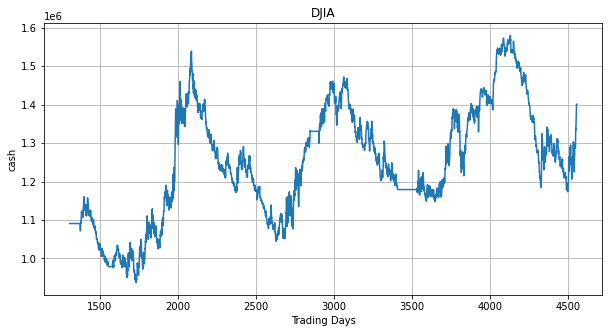

In [ ]:
fig = plt.figure()
axis=djia_test.loc[data_length_start:data_length_end-2,'cash'].plot(grid="True",figsize=(10,5), title='DJIA')
axis.set_xlabel("Trading Days")
axis.set_ylabel("Cash")
plt.show()

THANK YOU!!